# Mecanismos de Atenção

Neste notebook, iremos continuar nossos estudos de redes neurais recorrentes (RNNs), trabalhando mais uma vez com modelos `seq2seq` (*sequence-to-sequence*) para construir um tradutor de francês para inglês, uma ideia simples mas poderosa onde duas RNNs trabalham em conjunto para transformar uma sequência em outra. Agora, daremos um passo a mais, implementando um mecanismo de *additive attention*, como proposto pelo artigo [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf), de *Bahdanau et al.*

- Esse notebook foi fortemente inspirado no terceiro tutorial da série [NLP From Scratch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), disponibilizado no site do PyTorch.

A seguir, podemos observar o modelo `seq2seq` que implementamos até então.

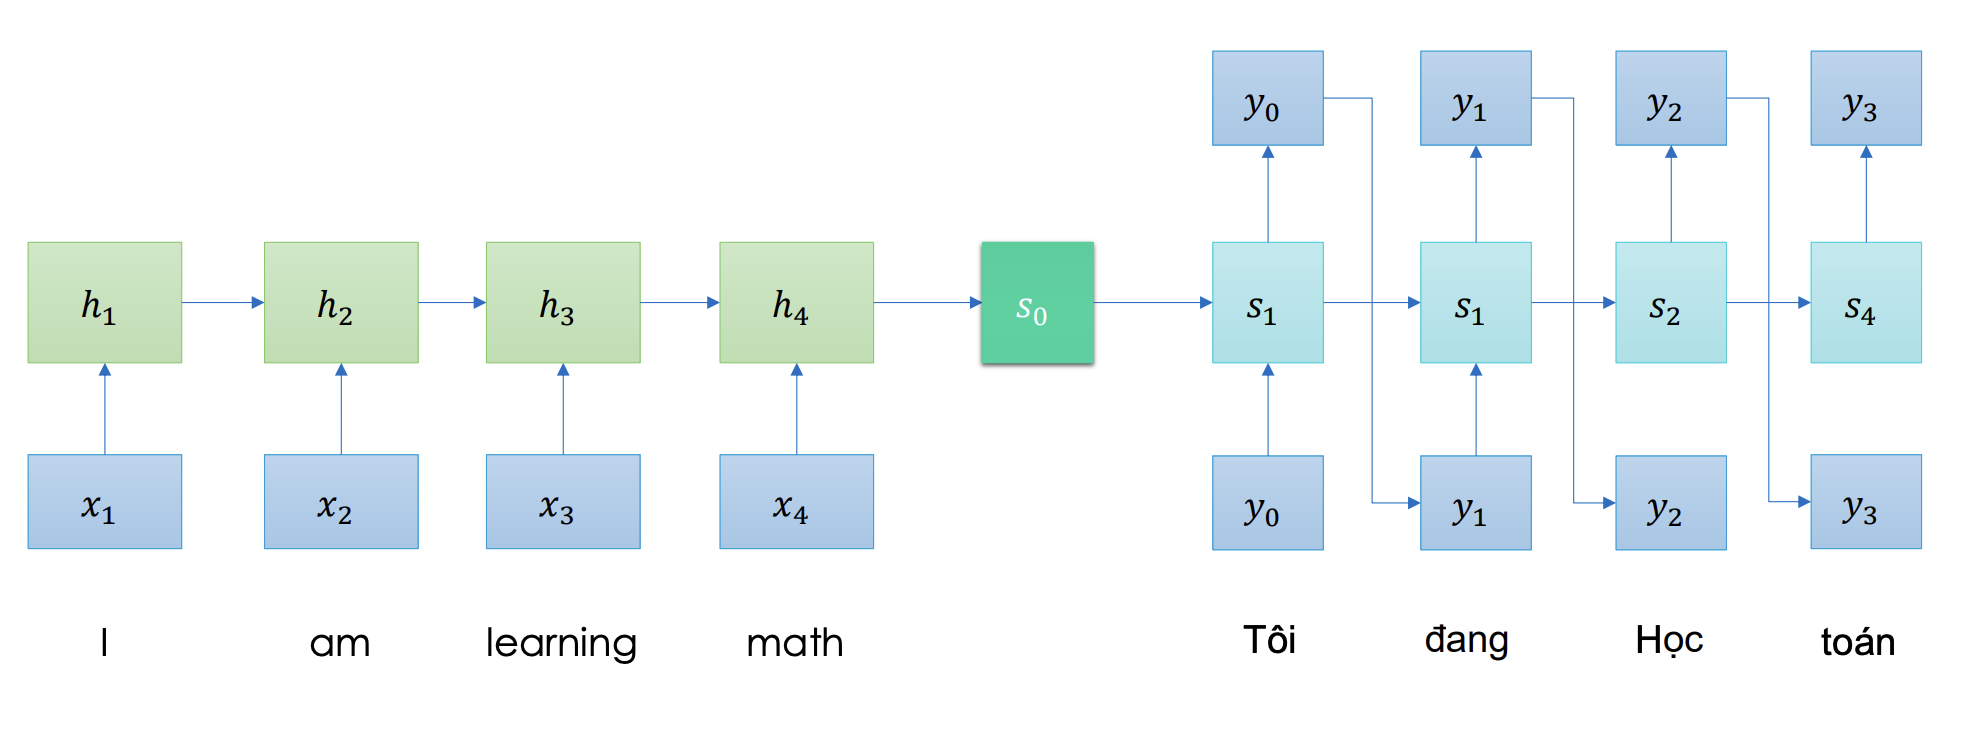

Como podemos perceber, estamos descartando as saídas da rede `encoder` para cada tempo $t$, utilizando apenas o último *hidden state* $H^{<t>}$, que chamamos de *vetor de contexto* da entrada. A ideia agora é não descartar as saídas intermediárias do `encoder`, utilizando cada saída intermediária como uma espécie de "*vetor de contexto intermediário*" para cada tempo $t$ da nossa entrada, auxiliando o `decoder` a prever *tokens* melhores para construir uma frase com uma ideia mais similar com a entrada. A manipulação desse *vetor de contexto intermediário* juntamente com a entrada do `decoder` constitui a teoria fundamental por trás do mecanismo de *attention*. A imagem abaixo representa o `decoder` com *attention*.

- **Importante:** Quando falamos saídas da rede `encoder`, estamos nos referindo também aos *hidden states*, uma vez que uma célula recorrente retorna a mesma informação tanto na horizontal (que chamamos de estados ocultos, ou *hidden states*) e na vertical (que chamamos de *saídas*). A **predição** de uma célula recorrente será a manipulação da sua saída através de uma outra rede, por exemplo uma MLP + softmax.



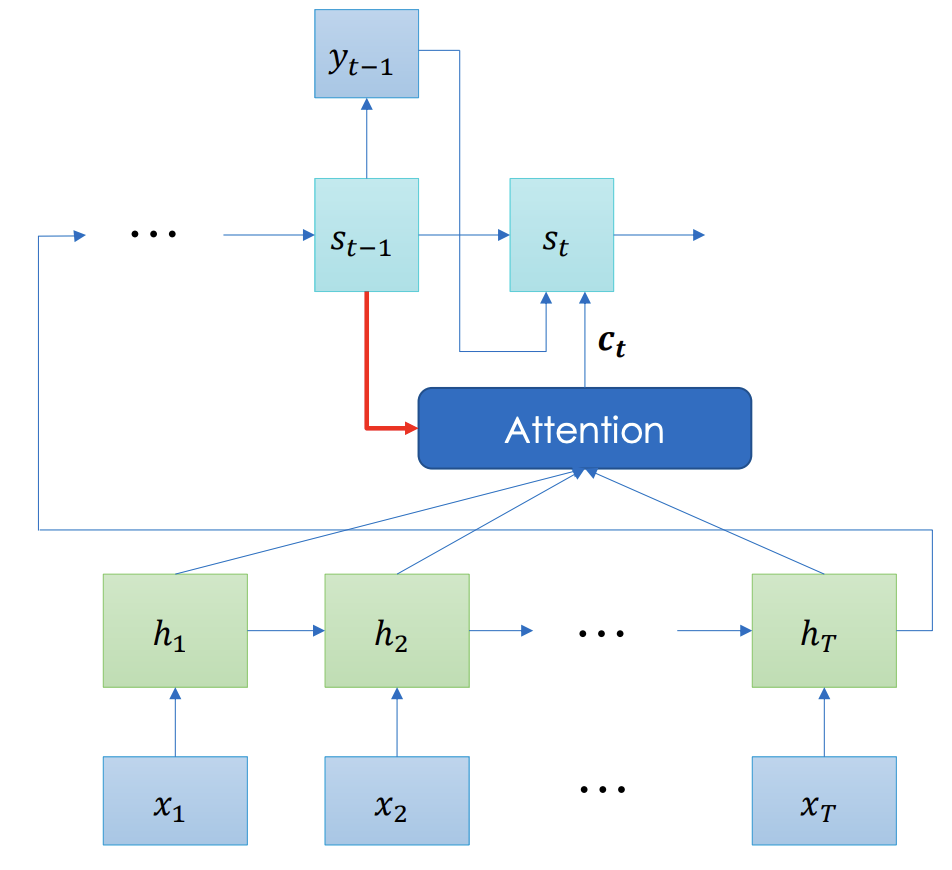

A seguir podemos observar em alto nível a ideia por trás do mecanismo de atenção e como que ele influência a predição da rede `decoder`.

![](https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/attention.gif?raw=true)

Com a teoria inicial semi-consolidada, conseguimos iniciar o código proposto por esse notebook. Note que iremos utilizar os mesmos dados da aula prática anterior de `seq2seq`. Iremos modificar apenas a rede `decoder` e realizar uma divisão dos dados em conjuntos de treino, validação e teste.

Se você estiver rodando esse notebook na Tatu, execute a seguinte célula de código.

Instalando pacotes necessários para realizarmos manipulações e outras operações com texto.

In [ ]:
!pip install unidecode

## Importação de pacotes

In [ ]:
import re
import torch
import random

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm
from unidecode import unidecode

from torch.utils.data import Dataset, DataLoader

In [ ]:
# Verificando se temos CUDA disponível e selecionando o device que será utilizado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

Device escolhido: cuda


## Entendimento da base de dados

A base de dados trabalhada durante esse notebook consiste em um arquivo `.txt` que possui pares de frases tanto em inglês quanto em francês, separados por um *tab*.

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip


--2025-07-05 22:32:40--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.96, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2025-07-05 22:32:40 (63.2 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Processamento da base de dados

De maneira similar à codificação feita em notebooks anteriores, iremos representar cada palavra de uma linguagem como sendo um índice numérico. Como iremos trabalhar com mais de uma linguagem, é natural criarmos uma classe, denominada de `Language`, para conter os dicionários que irão mapear palavras para índices (`word2idx`) e índices para palavras (`idx2word`).

Além disso, manteremos um terceiro dicionário chamado de `word_counter` para manter salvo a frequência de cada palavra nos dados daquela linguagem. Futuramente, iremos utilizar essa frequência para filtrar entradas que contém palavras raras, reduzindo assim a gigantesca base de dados para termos algo que executa de forma mais rápida, indiretamente facilitando o treinamento da nossa rede.

> Note que nesse notebook nós faremos o uso dos *tokens* especiais: **\<pad\>**, **\<sos\>** e **\<eos\>**, definindo de forma manual os índices relacionados com cada *token*.

In [ ]:
PAD_INDEX = 0
SOS_INDEX = 1
EOS_INDEX = 2

class Language:
    def __init__(self, name):
        self.name = name
        self.idx_counter = 3

        self.word2idx = {}
        self.word_counter = {}
        self.idx2word = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}

    def __len__(self):
        return self.idx_counter

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word_counter[word] = 1
            self.word2idx[word] = self.idx_counter
            self.idx2word[self.idx_counter] = word
            self.idx_counter += 1
        else:
            self.word_counter[word] += 1

    def trim(self, threshold):
        keep_words = []

        for word, count in self.word_counter.items():
            if count >= threshold:
                keep_words.append(word)

        ratio = len(keep_words) / len(self.word2idx)
        print(f'Razão de palavras mantidos: {ratio:.4f}')

        # Reinicializando dicionários
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}
        self.idx_counter = 3

        for word in keep_words:
            self.add_word(word)

Os textos do arquivo estão todos em [Unicode](https://pt.wikipedia.org/wiki/Unicode). Para simplificar o dado, iremos converter todos os caracteres Unicode em [ASCII](https://pt.wikipedia.org/wiki/ASCII), tornando tudo em caixa baixa e removendo boa parte dos sinais diacríticos através da função `preprocess_string`.

> O módulo `re` é para aproveitarmos do poder de utilizar *expressões regulares*, ou do inglês *regular expressions*, permitindo realizar casamento e processamento de *strings* rapidamente.

In [ ]:
def preprocess_string(string):
    ascii = unidecode(string).lower().strip()
    ascii = re.sub(r"([.!?])", r" \1", ascii)  # colocando um espaço entre texto e pontuação
    ascii = re.sub(r"[^a-zA-Z.!?]+", r" ", ascii)  # removendo tudo que não é um token válido
    ascii = ascii.strip()

    return ascii

# Exemplos de uso do preprocess_string
print(preprocess_string('kožušček'))
print(preprocess_string('François'))
print(preprocess_string("J'ai froid."))

kozuscek
francois
j ai froid .


Para ler os dados do arquivo `.txt`, nós iremos separar o conteúdo em linhas e depois cada linha em pares `(frase1, frase2)`. Como vimos anteriormente, as frases estão separadas por *tab* (`\t`), onde a primeira frase está em inglês e a segunda em francês. Já que queremos fazer uma tradução no sentido francês $\rightarrow$ inglês, iremos salvar os pares na ordem inversa, mantendo uma ideia de `(entrada, saída)`.

In [ ]:
def build_pairs():
    with open('data/eng-fra.txt', 'r') as fp:
        lines = fp.readlines()

    pairs = []
    for line in lines:
        sentence1, sentence2 = line.split('\t')
        pairs.append((preprocess_string(sentence2), preprocess_string(sentence1)))

    return pairs

pairs = build_pairs()
print('Número de pares:', len(pairs))
print('Exemplo dos primeiros 3 pares:', pairs[:3])

Número de pares: 135842
Exemplo dos primeiros 3 pares: [('va !', 'go .'), ('cours !', 'run !'), ('courez !', 'run !')]


Como temos muitos exemplos de frases, e queremos treinar algo relativamente rápido, iremos reduzir o número de sentenças e usar apenas entradas relativamente simples e curtas, com no máximo 10 palavras (incluindo `<eos>`). Além disso, iremos trabalhar apenas com entradas que traduzem para algo do tipo "*I am*", "*He is*", etc. Tudo isso será condensado na função `filter_pair`.

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am ', 'i m ',
    'he is', 'he s ',
    'she is', 'she s ',
    'you are', 'you re ',
    'we are', 'we re ',
    'they are', 'they re '
)

def filter_pair(pair):
    text1_length = len(pair[0].split(' '))
    text2_length = len(pair[1].split(' '))

    return text1_length < MAX_LENGTH and \
           text2_length < MAX_LENGTH and \
           pair[1].startswith(eng_prefixes)

pairs = list(filter(filter_pair, pairs))
print('Novo número de pares:', len(pairs))
print('Exemplo dos três primeiros novos pares:', pairs[:3])

Novo número de pares: 10601
Exemplo dos três primeiros novos pares: [('j ai ans .', 'i m .'), ('je vais bien .', 'i m ok .'), ('ca va .', 'i m ok .')]


Finalmente, iremos criar o escopo de cada linguagem que iremos trabalhar.

In [ ]:
def build_languages(pairs):
    input_language = Language('eng')
    output_language = Language('fra')

    for sentence1, sentence2 in pairs:
        input_language.add_sentence(sentence1)
        output_language.add_sentence(sentence2)

    return input_language, output_language

input_language, output_language = build_languages(pairs)
print(f'Número de tokens da linguagem {input_language.name}: {len(input_language)}')
print(f'Número de tokens da linguagem {output_language.name}: {len(output_language)}')
print('Exemplo aleatório de um par:', random.choice(pairs))

Número de tokens da linguagem eng: 4350
Número de tokens da linguagem fra: 2805
Exemplo aleatório de um par: ('elle donne a chaque enfant deux pommes .', 'she s giving each child two apples .')


## Construção de um `Dataset` e `DataLoader`

Finalmente, iremos estudar uma forma de agrupar sequências de tamanhos diferentes em um único *batch* de dados, permitindo trabalhar com `batch_size` em modelos recorrentes.

Para isso, faremos um uso extensivo do módulo `torch.nn.utils.rnn`, ou `rnn_utils` como definimos nos imports no começo desse notebook. A partir desse módulo, conseguimos aplicar *padding* em um conjunto de sequências, uniformizando o tamanho das sequências. Além disso, PyTorch disponibiliza um tipo específico de dados chamado de `PackedSequence`, destinado exclusivamente para modelos recorrentes, onde podemos usar as funções `pack_padded_sequence` e `pad_packed_sequence`, para converter de tensores para `PackedSequences` e vice-versa.

> **Importante:** O uso de `PackedSequences` é interessante quando trabalhamos com dados de tamanho variável, uma vez que os modelos do PyTorch conseguem efetivamente "pular" *tokens* `<pad>`, poupando memória e computação! Porém, o seu uso é bastante confuso e mal documentado. Como alternativa, podemos criar uma máscara e mascarar a função de perda do nosso modelo, fazendo com que gradientes associados com `<pad>` não sejam usados durante a atualização dos pesos da rede.

Como estamos trabalhando com sequências de tamanho variável, precisamos "ensinar" para o PyTorch como que iremos "colar" todas essas sequências para formar um único *batch*. Isso pode ser feito através da definição de uma função chamada `collate_fn` (algo como função de combinação), onde nela podemos usar a função `pad_sequence` para conseguir construir um *batch* de dados sem problemas. Aqui, iremos construir um tensor que já tem o tamanho máximo, predefinido anteriormente no código, descartando a necessidade de termos uma `collate_fn`.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos em cenários `seq2seq`, além de como utilizar modelos mais complexos como GRUs e LSTMs.

In [ ]:
def sentence2tensor(sentence, is_input=True):
    tensor = torch.full((MAX_LENGTH,), PAD_INDEX, dtype=torch.long)
    language = input_language if is_input else output_language

    words = sentence.split(' ')
    for idx, word in enumerate(words):
        tensor[idx] = language.word2idx[word]

    tensor[len(words)] = EOS_INDEX
    return tensor

def tensor2sentence(tensor, is_input=True):
    language = input_language if is_input else output_language
    return ' '.join(language.idx2word[idx.item()] for idx in tensor)

class TranslationDataset(Dataset):
    def __init__(self, idxs):
        self.pairs = []
        for idx in idxs:
            self.pairs.append(pairs[idx])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_sentence, output_sentence = self.pairs[idx]
        input_tensor = sentence2tensor(input_sentence, is_input=True)
        output_tensor = sentence2tensor(output_sentence, is_input=False)

        return input_tensor, output_tensor

Separando pares para treino, validação e teste com proporção 8:1:1 (80%, 10% e 10%).

In [ ]:
from sklearn.model_selection import train_test_split

total_idxs = list(range(len(pairs)))
train_idxs, validation_idxs = train_test_split(total_idxs, test_size=0.2, shuffle=True)
validation_idxs, test_idxs = train_test_split(validation_idxs, test_size=0.5, shuffle=True)

train_dataset = TranslationDataset(train_idxs)
validation_dataset = TranslationDataset(validation_idxs)
test_dataset = TranslationDataset(test_idxs)

print(f'Porcentagem de amostras de treino: {100 * (len(train_dataset) / len(total_idxs)):.2f}%')
print(f'Porcentagem de amostras de validação: {100 * (len(validation_dataset) / len(total_idxs)):.2f}%')
print(f'Porcentagem de amostras de teste: {100 * (len(test_dataset) / len(total_idxs)):.2f}%')

Porcentagem de amostras de treino: 79.99%
Porcentagem de amostras de validação: 10.00%
Porcentagem de amostras de teste: 10.01%


Exemplo de uma amostra do `TranslationDataset`.

In [ ]:
input_tensor, output_tensor = train_dataset[42]

print('Tensor de entrada:', input_tensor)
print('Tensor de saída. :', output_tensor)

print('\nFrase de entrada:', tensor2sentence(input_tensor, is_input=True))
print('Frase de saída   :', tensor2sentence(output_tensor, is_input=False))

Tensor de entrada: tensor([   7,   12,  111,  418,    7,  119,    4, 3714,    6,    2])
Tensor de saída. : tensor([   3,    4,   70, 1373,    3, 2229,  130,    5,    2,    0])

Frase de entrada: je suis desolee si je vous ai effrayes . <eos>
Frase de saída   : i m sorry if i frightened you . <eos> <pad>


Exemplo de uma amostra do nosso `DataLoader`.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

input_tensor, output_tensor = next(iter(train_dataloader))
print('Tamanho da entrada e saída:', (input_tensor.shape, output_tensor.shape))

Tamanho da entrada e saída: (torch.Size([32, 10]), torch.Size([32, 10]))


In [ ]:
first_input = input_tensor[0]
first_output = output_tensor[0]

print('Tensor de entrada:', first_input)
print('Tensor de saída  :', first_output)

print('\nFrase de entrada:', tensor2sentence(first_input, is_input=True))
print('Frase de saída   :', tensor2sentence(first_output, is_input=False))

Tensor de entrada: tensor([   7,   12,   52, 1365,   25, 2846,    6,    2,    0,    0])
Tensor de saída  : tensor([   3,   17,   34,  696,   15, 1701, 1462,    5,    2,    0])

Frase de entrada: je suis sur qu il reussira . <eos> <pad> <pad>
Frase de saída   : i am sure that he will succeed . <eos> <pad>


## Modelo Encoder-Decoder

Uma rede *sequence to sequence*, *seq2seq*, ou rede *encoder-decoder*, é um modelo que é composto por 2 RNNs, denominadas de *encoder* e *decoder*. O papel do *encoder* é de ler a sequência de entrada e gerar um **contexto** da entrada (última camada de *hidden state*); enquanto o *decoder* utilizará esse **contexto** para produzir uma sequência de saída. Esse tipo de modelagem permite que modelos *seq2seq* produzam uma sequência de tamanho diferente da sequência de entrada, sendo ideal para traduções por exemplo.

![](https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/seq2seq.png?raw=true)

Além disso, por produzir um vetor de **contexto**, o modelo consegue lidar com problemas relacionado à ordem das palavras em diferentes línguas. Considere a sentença: *Je ne suis pas le chat noir*, traduzida para *I am not the black cat*. Perceba que boa parte das palavras da entrada possuem uma tradução 1:1 com as palavras da saída, mas em uma ordem um pouco diferente, como no caso de *chat noir* ser traduzido para *black cat*.

1. Implemente a rede `Encoder`.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        """
        Implementação de um encoder para o modelo seq2seq.

        Argumentos
        ----------
            vocab_size (int): tamanho do nosso vocabulário.
            embed_size (int): dimensão do embedding que usaremos.
            hidden_size (int): dimensão do estado oculto das camadas recorrentes.
        """

        super().__init__()
        # Implemente aqui sua solução
        self.vocab_size =  vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.dropout = nn.Dropout(0.5)
        self.rnn = nn.LSTM(embed_size,hidden_size, 3, batch_first=True)

    def forward(self, x):
        # Implemente aqui sua solução
        x = self.embedding(x)
        x = self.dropout(x)
        output, context = self.rnn(x)

        return output, context

> **Notas:** É muito comum observarmos uma camada de *dropout* depois da camada de *embedding* na rede *encoder*. Aqui, o *dropout* atua no sentido de desconsiderar alguns *tokens* da entrada da rede, aumentando a capacidade da rede de aprender a traduzir uma frase mesmo com *tokens* faltantes.

2. Implemente a rede `Decoder` e o mecanismo de *Attention*.

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def forward(self, query, keys):
        query = query.unsqueeze(1)
        scores = torch.bmm(query, keys.transpose(1, 2))
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attention_weights, keys).squeeze(1)
        return context, attention_weights.squeeze(1)


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=3):
        """
        Implementação de um encoder para o modelo seq2seq.

        Argumentos
        ----------
            vocab_size (int): tamanho do nosso vocabulário.
            embed_size (int): dimensão do embedding que usaremos.
            hidden_size (int): dimensão do estado oculto das camadas recorrentes.
        """

        super().__init__()
        # Implemente aqui sua solução
        self.vocab_size =  vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.dropout = nn.Dropout(0.5)
        self.attention = Attention(hidden_size)
        # input: embedding + contexto
        self.lstm = nn.LSTM(self.embed_size + hidden_size, self.hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size + hidden_size, self.vocab_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, max_length=50, sos_idx=1, eos_idx=2):
        """
        Método de forward da rede.

        Argumentos
        ----------
            encoder_outputs (torch.Tensor): saídas em cada tempo t do encoder
            encoder_hidden (torch.Tensor): último estado oculto do encoder
            target_tensor (torch.Tensor ou None): tensor da sentença alvo (usado para teacher forcing); None para inferência.
            max_length (int): comprimento máximo para geração na inferência.
            sos_idx (int): índice do token <sos>.
            eos_idx (int): índice do token <eos>.
        """
        # Implemente aqui sua solução
        outputs = []
        attentions = []

        hidden, cell = encoder_hidden

        if target_tensor is not None:
            batch_size, target_sequence_len = target_tensor.shape
            input_token = target_tensor[:, 0]
            for t in range(target_sequence_len):
                embedded = self.dropout(self.embedding(input_token)).unsqueeze(1)

                context, attn_weights = self.attention(hidden[-1], encoder_outputs)
                context = context.unsqueeze(1)
                rnn_input = torch.cat([embedded, context], dim=2)

                output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
                output = output.squeeze(1)
                context = context.squeeze(1)

                pred_input = torch.cat([output, context], dim=1)
                output = self.fc(pred_input)
                output = F.log_softmax(output, dim=-1)
                outputs.append(output)
                attentions.append(attn_weights)

                if t+1 < target_sequence_len:
                    input_token = target_tensor[:, t+1]

            outputs = torch.stack(outputs, dim=1)
            attentions = torch.stack(attentions, dim=1)
            return outputs, attentions
        else:
            batch_size = encoder_outputs.size(0)
            input_token = torch.full((batch_size,), sos_idx, dtype=torch.long, device=encoder_outputs.device)
            ended = torch.zeros(batch_size, dtype=torch.bool, device=encoder_outputs.device)
            for t in range(max_length):
                embedded = self.dropout(self.embedding(input_token)).unsqueeze(1)

                context, attn_weights = self.attention(hidden[-1], encoder_outputs)
                context = context.unsqueeze(1)
                rnn_input = torch.cat([embedded, context], dim=2)

                output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
                output = output.squeeze(1)
                context = context.squeeze(1)

                pred_input = torch.cat([output, context], dim=1)
                output = self.fc(pred_input)
                output = F.log_softmax(output, dim=-1)
                outputs.append(output)
                attentions.append(attn_weights)

                input_token = output.argmax(dim=-1)
                ended = ended | (input_token == eos_idx)
                input_token = input_token.masked_fill(ended, eos_idx)
                if ended.all():
                    break

            outputs = torch.stack(outputs, dim=1)
            attentions = torch.stack(attentions, dim=1)
            return outputs, attentions


Verificando o comportamento da rede com um *batch* aleatório.

In [ ]:
encoder = Encoder(len(input_language), embed_size=32, hidden_size=64).to(device)
decoder = Decoder(len(output_language), embed_size=32, hidden_size=64).to(device)

x, y = next(iter(train_dataloader))
x = x.to(device)
y = y.to(device)

encoder_outputs, context = encoder(x)
outputs, attentions = decoder(encoder_outputs, context, y)
predictions = outputs.argmax(dim=-1)

print('Frase original   :', tensor2sentence(x[0], is_input=True))
print('Tradução original:', tensor2sentence(y[0], is_input=False))
print('Tradução da rede :', tensor2sentence(predictions[0], is_input=False))

Frase original   : vous etes fort attirantes . <eos> <pad> <pad> <pad> <pad>
Tradução original: you re very attractive . <eos> <pad> <pad> <pad> <pad>
Tradução da rede : distracted distracted distracted distracted distracted argue argue distracted distracted distracted


## Treinamento do modelo

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    encoder.train()
    decoder.train()

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, context = encoder(X)
        outputs, attentions = decoder(encoder_outputs, context, y)

        loss = criterion(outputs.transpose(1, 2), y)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    total_loss /= len(dataloader)
    return total_loss

In [ ]:
def evaluate_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            encoder_outputs, context = encoder(X)
            outputs, attentions = decoder(encoder_outputs, context, y)

            loss = criterion(outputs.transpose(1, 2), y)
            total_loss += loss.item()

    total_loss /= len(dataloader)
    return total_loss

In [ ]:
batch_size = 32
num_epochs = 50

print_every = 5
save_loss_every = 5

train_dataset = TranslationDataset(train_idxs)
validation_dataset = TranslationDataset(validation_idxs)
test_dataset = TranslationDataset(test_idxs)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

encoder = Encoder(len(input_language), embed_size=100, hidden_size=128).to(device)
decoder = Decoder(len(output_language), embed_size=100, hidden_size=128).to(device)

criterion = nn.NLLLoss(ignore_index=PAD_INDEX)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.00005)

train_losses = []
validation_losses = []

save_train_loss = 0
print_train_loss = 0

start_time = time()

for epoch in range(1, num_epochs + 1):
    loss = train_epoch(train_dataloader, encoder, decoder,
                       encoder_optimizer, decoder_optimizer, criterion)

    save_train_loss += loss
    print_train_loss += loss

    if epoch % print_every == 0:
        print_train_loss /= print_every
        validation_loss = evaluate_epoch(validation_dataloader, encoder, decoder, criterion)
        elapsed_time = time() - start_time

        print(f'Epoch [{epoch}/{num_epochs}] => average training loss: {print_train_loss:.5f}, ' \
              f'average validation loss: {validation_loss:.5f}, elapsed time: {elapsed_time:.2f} seconds')

        print_train_loss = 0

    if epoch % save_loss_every == 0:
        save_train_loss /= save_loss_every
        validation_loss = evaluate_epoch(validation_dataloader, encoder, decoder, criterion)

        train_losses.append(save_train_loss)
        validation_losses.append(validation_loss)

        save_train_loss = 0

Epoch [5/50] => average training loss: 4.23937, average validation loss: 3.36562, elapsed time: 41.76 seconds
Epoch [10/50] => average training loss: 2.97845, average validation loss: 2.78590, elapsed time: 84.40 seconds
Epoch [15/50] => average training loss: 2.61756, average validation loss: 2.55436, elapsed time: 126.81 seconds
Epoch [20/50] => average training loss: 2.39932, average validation loss: 2.38529, elapsed time: 168.12 seconds
Epoch [25/50] => average training loss: 2.21543, average validation loss: 2.20072, elapsed time: 211.00 seconds
Epoch [30/50] => average training loss: 2.04358, average validation loss: 2.06260, elapsed time: 252.27 seconds
Epoch [35/50] => average training loss: 1.89063, average validation loss: 1.93477, elapsed time: 294.44 seconds
Epoch [40/50] => average training loss: 1.75611, average validation loss: 1.83159, elapsed time: 336.57 seconds
Epoch [45/50] => average training loss: 1.63429, average validation loss: 1.73496, elapsed time: 378.42 sec

Plotando o gráfico da função de perda ao longo das épocas.

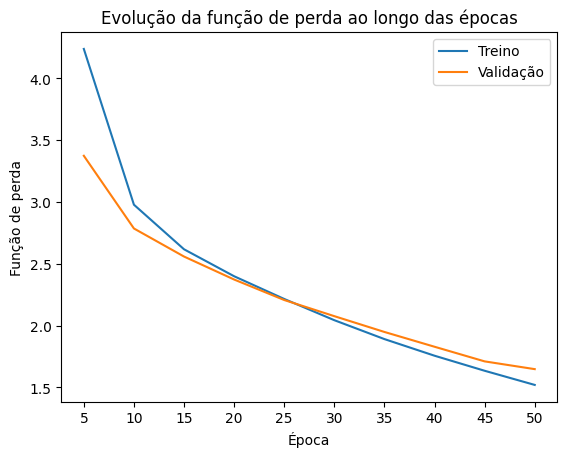

In [ ]:
plt.title('Evolução da função de perda ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Função de perda')

plt.plot(train_losses, label='Treino')
plt.plot(validation_losses, label='Validação')
plt.xticks(range(len(train_losses)), range(save_loss_every, num_epochs+1, save_loss_every))

plt.legend()
plt.show()

## Avaliação qualitativa dos resultados

O método de **predição** da rede é similar ao treinamento e validação. Porém, dessa vez nós não iremos aplicar *teacher forcing*, uma vez que não temos a palavra-alvo para o tempo $t$. Sendo assim, a predição do tempo $t$ será dada pela **previsão** da rede *decoder* no tempo $t-1$. Além disso, caso a rede preveja um *token* `<eos>`, iremos parar a geração antes de gerar uma sentença com o tamanho máximo.

In [ ]:
def predict(x, encoder, decoder):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoder_outputs, context = encoder(x)
        decoder_outputs, decoder_attn = decoder(encoder_outputs, context)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_INDEX:
                decoded_words.append('<eos>')
                break

            decoded_words.append(output_language.idx2word[idx.item()])

    return decoded_words, decoder_attn

In [ ]:
def show_attention(input_sentence, output_sentence, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    n_input = len(input_sentence.split(' '))
    n_output = len(output_sentence.split(' '))

    attentions = attentions.squeeze()
    attentions = attentions[:n_output, :n_input]
    cax = ax.matshow(attentions.squeeze().cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    xticks = input_sentence.split(' ')
    yticks = output_sentence.split(' ')
    ax.set_xticks(range(len(xticks)), xticks, rotation=90)
    ax.set_yticks(range(len(yticks)), yticks)

    plt.show()

> ce sont celles qui veulent partir . <eos> <pad> <pad>
= they are the ones who want to go . <eos>
< they are good to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to


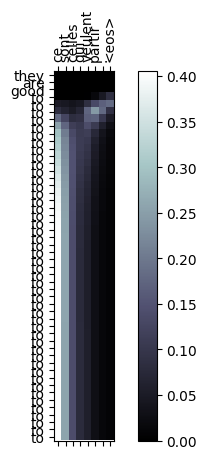

In [ ]:
x, y = test_dataset[0]
sentence = tensor2sentence(x, is_input=True)

x_in = x.unsqueeze(0).to(device)
predictions, attns = predict(x_in, encoder, decoder)
output_sentence = ' '.join(predictions)

print(f'> {sentence}')
print(f'= {tensor2sentence(y, is_input=False)}')
print(f"< {output_sentence}")

sentence_without_pad = []
for word in sentence.split(' '):
    if word != '<pad>':
        sentence_without_pad.append(word)

sentence_without_pad = ' '.join(sentence_without_pad)
show_attention(sentence_without_pad, output_sentence, attns)

> je me fais du souci pour lui . <eos> <pad>
= i am worried about him . <eos> <pad> <pad> <pad>
< he am no at at at at at at at at at at at at car here <eos>


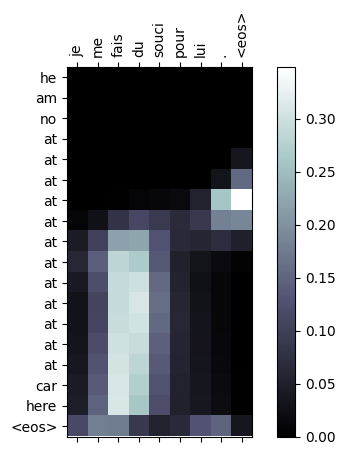

In [ ]:
x, y = test_dataset[10]
sentence = tensor2sentence(x, is_input=True)

x_in = x.unsqueeze(0).to(device)
predictions, attns = predict(x_in, encoder, decoder)
output_sentence = ' '.join(predictions)

print(f'> {sentence}')
print(f'= {tensor2sentence(y, is_input=False)}')
print(f"< {output_sentence}")

sentence_without_pad = []
for word in sentence.split(' '):
    if word != '<pad>':
        sentence_without_pad.append(word)

sentence_without_pad = ' '.join(sentence_without_pad)
show_attention(sentence_without_pad, output_sentence, attns)

> tu es remarquable . <eos> <pad> <pad> <pad> <pad> <pad>
= you re remarkable . <eos> <pad> <pad> <pad> <pad> <pad>
< you re very very very very ! <eos>


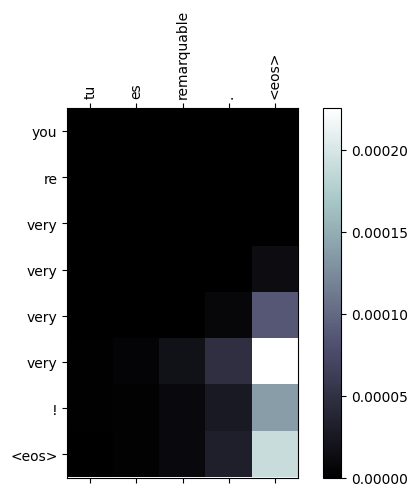

In [ ]:
x, y = test_dataset[42]
sentence = tensor2sentence(x, is_input=True)

x_in = x.unsqueeze(0).to(device)
predictions, attns = predict(x_in, encoder, decoder)
output_sentence = ' '.join(predictions)

print(f'> {sentence}')
print(f'= {tensor2sentence(y, is_input=False)}')
print(f"< {output_sentence}")

sentence_without_pad = []
for word in sentence.split(' '):
    if word != '<pad>':
        sentence_without_pad.append(word)

sentence_without_pad = ' '.join(sentence_without_pad)
show_attention(sentence_without_pad, output_sentence, attns)